In [1]:
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset
from sklearn.metrics import accuracy_score

import shap

In [2]:
batch_size = 128
num_epochs = 100

# device = torch.device("cpu")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.RandomCrop(96, padding=4),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])


# Download and load the training dataset
train_dataset = torchvision.datasets.STL10(
    root='./data',  # Directory to save the dataset
    split='train',  # Use the labeled training split
    download=True,  # Download the dataset if not already downloaded
    transform=transform
)

# Download and load the test dataset
test_dataset = torchvision.datasets.STL10(
    root='./data',
    split='test',  # Use the test split
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


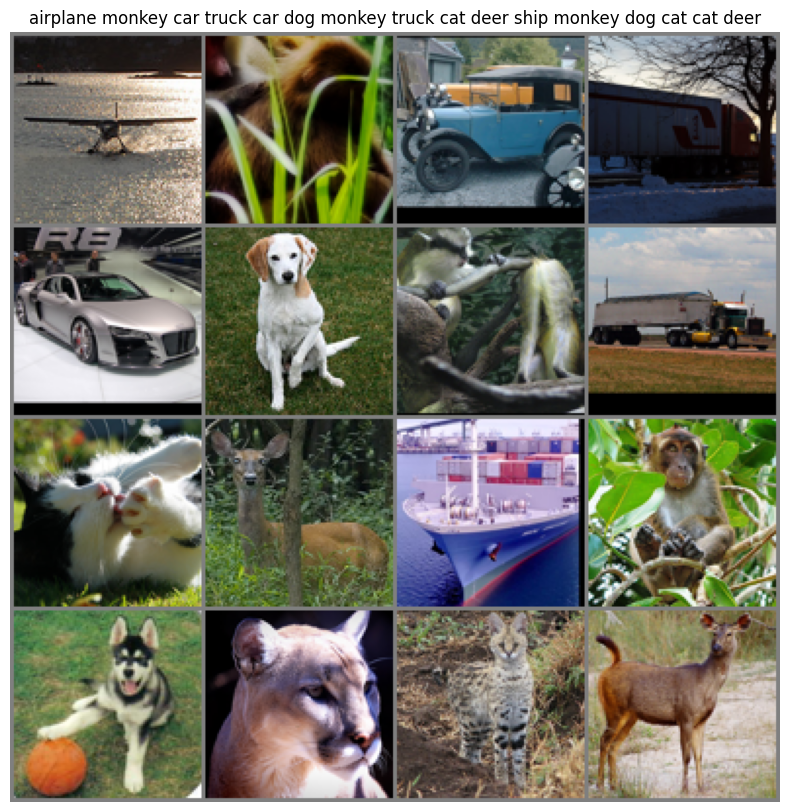

In [3]:
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize the image to [0, 1]
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Get one batch of images and labels
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Get class names
classes = train_dataset.classes

# Display a batch of images with class names
imshow(torchvision.utils.make_grid(images[:16], nrow=4),  # Show first 16 images in a grid
       title=' '.join(classes[labels[j]] for j in range(16)))

In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        # out += identity
        out = out + identity
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10, grayscale=False):
        super(ResNet18, self).__init__()
        in_channels = 1 if grayscale else 3  # Adjust input channels for grayscale
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x


class TargetModelWithActivations(nn.Module):
    def __init__(self, target_model):
        super(TargetModelWithActivations, self).__init__()
        self.target_model = target_model
        self.features = nn.Sequential(
            target_model.conv1,
            target_model.bn1,
            target_model.relu,
            target_model.maxpool,
            target_model.layer1,
            target_model.layer2,
            target_model.layer3,
            target_model.layer4,  # Extract activations here
        )
        self.avgpool = target_model.avgpool
        self.fc = target_model.fc

    def forward(self, x):
        features = self.features(x)
        out = self.avgpool(features)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return features, out



In [5]:


#print(resnet18)


In [ ]:
# model = ResNet18(grayscale=False,num_classes=10)
# model

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(F.log_softmax(output, dim=1), target)
        loss.backward()
        optimizer.step()

        # Compute accuracy for the current batch
        pred = output.max(1, keepdim=True)[1]  # Get predictions
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        # Log progress dynamically for every batch
        print(
            f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
            f" ({100.0 * batch_idx * len(data) / len(train_loader.dataset):.0f}%)]"
            f"\tLoss: {loss.item():.6f}"
        )

    # Display epoch training accuracy
    accuracy = 100.0 * correct / total
    print(f"Train Epoch: {epoch} Accuracy: {accuracy:.2f}%")





# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(F.log_softmax(output, dim=1), target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 100 == 0:
#             print(
#                 f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
#                 f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
#                 f"\tLoss: {loss.item():.6f}"
#             )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(F.log_softmax(output, dim=1), target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f},"
        f" Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100.0 * correct / len(test_loader.dataset):.0f}%)\n"
    )

# num_epochs  = 100


model = ResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01,weight_decay=1e-4)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

In [ ]:
# target_model
torch.save(model.state_dict(), "resnet18_stl10.pth")

target_model = model

In [6]:
#Attack model training
target_model = ResNet18(grayscale=False,num_classes=10).to(device)
target_model.load_state_dict(torch.load('resnet18_stl10.pth'))  # Load your trained model weights

target_model

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [7]:
member_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)  # Member data (train data)
non_member_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
hidden_activations = []

def save_activation(module, input, output):
    hidden_activations.append(output)

target_model.layer4[1].register_forward_hook(save_activation)


def get_hidden_activations(model, data_loader, device):
    model.eval()
    all_activations = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            
            # Clear the activations list
            global hidden_activations
            hidden_activations = []
            
            # Forward pass
            _ = model(images)  # Only need to run forward to trigger the hook
            
            # Retrieve the activations from the hook
            #activations = hidden_activations[0]
            activations = hidden_activations[0].view(images.size(0), -1)
            
            all_activations.append(activations.cpu())
            all_labels.append(labels)
            
    return torch.cat(all_activations), torch.cat(all_labels)


In [9]:
##Attack model architecture
class AttackModel(nn.Module):
    def __init__(self, input_dim):
        super(AttackModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Binary output (member or non-member)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Initialize attack model
hidden_activation_dim = 512 * 3 *3
attack_model = AttackModel(input_dim=hidden_activation_dim)
attack_model = attack_model.to(device)

In [10]:
member_activations, member_labels = get_hidden_activations(target_model, member_loader, device)
non_member_activations, non_member_labels = get_hidden_activations(target_model, non_member_loader, device)

member_labels = torch.ones(member_activations.size(0))  # Label 1 for members
non_member_labels = torch.zeros(non_member_activations.size(0))  # Label 0 for non-members

attack_data = torch.cat([member_activations, non_member_activations])
attack_labels = torch.cat([member_labels, non_member_labels])

attack_dataset = TensorDataset(attack_data, attack_labels)
attack_loader = DataLoader(attack_dataset, batch_size=64, shuffle=True)

In [11]:
member_activations.shape,non_member_activations.shape

(torch.Size([5000, 4608]), torch.Size([8000, 4608]))

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(attack_model.parameters(), lr=1e-4)

# Training loop
num_epochs = 50
attack_model.train()
for epoch in range(num_epochs):
    for batch_activations, batch_labels in attack_loader:
        batch_activations, batch_labels = batch_activations.to(device), batch_labels.to(device)

        # Forward pass
        outputs = attack_model(batch_activations)
        loss = criterion(outputs.squeeze(), batch_labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
torch.save(attack_model.state_dict(), "stl10_attack_model_weights.pth")
print("Attack model weights saved successfully.")

In [12]:
attack_model.load_state_dict(torch.load("stl10_attack_model_weights.pth"))
attack_model.eval()  # Set the model to evaluation mode
print("Attack model weights loaded successfully.")

def evaluate_attack_model(attack_model, data, labels, threshold=0.5):
    attack_model.eval()
    with torch.no_grad():
        data = data.to(device)
        labels = labels.to(device)
        
        # Get predictions
        outputs = attack_model(data).squeeze()
        predictions = (outputs > threshold).float()  # Apply threshold to get binary predictions
        
        # Calculate accuracy
        accuracy = accuracy_score(labels.cpu(), predictions.cpu())
        print(f"Attack Model Accuracy: {accuracy * 100:.2f}%")
        
    return accuracy

# Test the attack model accuracy
evaluate_attack_model(attack_model, attack_data.to(device), attack_labels.to(device))

Attack model weights loaded successfully.
Attack Model Accuracy: 99.65%


0.9964615384615385

In [13]:
class CombinedModel(nn.Module):
    def __init__(self, target_model, attack_model):
        super(CombinedModel, self).__init__()
        self.target_model = TargetModelWithActivations(target_model)
        self.attack_model = attack_model

    # def forward(self, x):
    #     features, _ = self.target_model(x)  # Get intermediate features
    #     flattened_features = features.view(x.size(0), -1)
    #     attack_output = self.attack_model(flattened_features)
    #     return attack_output
    def forward(self, x):
        features, _ = self.target_model(x)  # Get intermediate features
        # Ensure features are contiguous before reshaping
        flattened_features = features.contiguous().view(x.size(0), -1)
        attack_output = self.attack_model(flattened_features)
        return attack_output



In [14]:
combined_model = CombinedModel(target_model, attack_model).to(device)


In [16]:
data_iter_test = iter(test_loader)
X_test, y_test = next(data_iter_test)

2024-11-19 11:02:35.209423: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 11:02:35.216547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 11:02:35.224683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 11:02:35.226989: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 11:02:35.233457: I tensorflow/core/platform/cpu_feature_guar

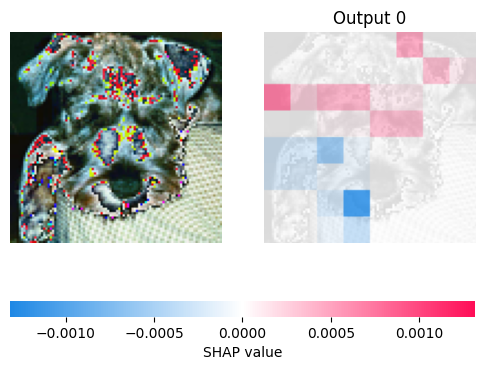

In [17]:
# Preprocess X_test to convert from [C, H, W] to [H, W, C]
X_test_numpy = X_test.permute(0, 2, 3, 1).numpy()  # [B, C, H, W] -> [B, H, W, C]

# Ensure the data type is uint8 and values are scaled to [0, 255]
X_test_numpy = (X_test_numpy * 255).astype(np.uint8)

# Define the masker with the corrected shape
masker = shap.maskers.Image("inpaint_telea", X_test_numpy[0].shape)

# Define the model function for SHAP
def f(x):
    # Convert from [B, H, W, C] to [B, C, H, W] for PyTorch
    x_tensor = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    with torch.no_grad():
        return combined_model(x_tensor).cpu().numpy()

# Initialize SHAP explainer
explainer = shap.Explainer(f, masker)

# Explain two images using SHAP
shap_values = explainer(X_test_numpy[50:82], max_evals=100, batch_size=1)

# Plot the SHAP values
shap.image_plot(shap_values, X_test_numpy[50:51])


In [ ]:
shap_values.shape

In [ ]:

def denormalize(img):
    return img * 0.5 + 0.5
test_batch, test_labels = next(iter(train_loader))#test_loader,,#train_loader
test_batch = test_batch.to(device)

combined_output = combined_model(test_batch)
predictions = (combined_output > 0.5).float()

half = len(test_batch) // 2
attack_labels = torch.cat([torch.ones(half), torch.zeros(len(test_batch) - half)]).to(device)

# correct = (predictions.squeeze() == attack_labels).sum().item()
# accuracy = correct / len(attack_labels) * 100
# print(f"Combined Model Test Accuracy: {accuracy:.2f}%")

test_images = test_batch.cpu()
for i in range(5):  # Show 5 images
    img = denormalize(test_images[i])
    label = "Member" if predictions[i].item() > 0.5 else "Non-Member"
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()


In [ ]:
# Evaluate CombinedModel on member data
member_batch, _ = next(iter(member_loader))  # Fetch a batch of member data
member_batch = member_batch.to(device)
member_output = combined_model(member_batch)
member_predictions = (member_output > 0.5).float()
member_labels = torch.ones(member_batch.size(0)).to(device)  # All ones (member)

member_correct = (member_predictions.squeeze() == member_labels).sum().item()
member_accuracy = member_correct / len(member_labels) * 100
print(f"Member Data Accuracy: {member_accuracy:.2f}%")

# Evaluate CombinedModel on non-member data
non_member_batch, _ = next(iter(non_member_loader))  # Fetch a batch of non-member data
non_member_batch = non_member_batch.to(device)
non_member_output = combined_model(non_member_batch)
non_member_predictions = (non_member_output > 0.5).float()
non_member_labels = torch.zeros(non_member_batch.size(0)).to(device)  # All zeros (non-member)

non_member_correct = (non_member_predictions.squeeze() == non_member_labels).sum().item()
non_member_accuracy = non_member_correct / len(non_member_labels) * 100
print(f"Non-Member Data Accuracy: {non_member_accuracy:.2f}%")

# Combined accuracy
total_correct = member_correct + non_member_correct
total_samples = len(member_labels) + len(non_member_labels)
total_accuracy = total_correct / total_samples * 100
print(f"Combined Model Accuracy: {total_accuracy:.2f}%")


In [ ]:
combined_model.to(device)

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, target_model, attack_model):
        super(CombinedModel, self).__init__()
        self.target_model = target_model
        self.attack_model = attack_model

        # Register hook to capture activations dynamically
        self.activation = None

        def save_activation(module, input, output):
            print(f"Captured activation shape: {output.shape}")
            self.activation = output  # Store activations in a local variable

        self.target_model.layer4[1].register_forward_hook(save_activation)

    def forward(self, x):
        # Forward pass through target model
        _ = self.target_model(x)

        if self.activation is None:
            raise RuntimeError("Hook did not capture any activations.")

        # Process activations for attack model
        hidden_features = self.activation.view(x.size(0), -1)

        # Forward pass through attack model
        attack_output = self.attack_model(hidden_features)
        return attack_output
combined_model = CombinedModel(target_model, attack_model).to(device)

In [ ]:
# Fetch a batch of test data
# Disable CuDNN for testing SHAP
torch.backends.cudnn.enabled = False

# Fetch background and test images
batch = next(iter(test_loader))
images, _ = batch
background = images[:100].to(device)
test_images = images[100:103].to(device)

# Initialize SHAP GradientExplainer (use DeepExplainer if problem resolves)
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

# Convert SHAP values and test images for visualization
shap_numpy = [np.transpose(s, (1, 2, 3, 0)) for s in shap_values]
test_numpy = np.transpose(test_images.cpu().numpy(), (0, 2, 3, 1))

# Visualize SHAP explanations
shap.image_plot(shap_numpy, test_numpy)




In [ ]:
batch = next(iter(test_loader))
images, _ = batch

background = images[:100].to(device)  # 100 background samples
test_images = images[100:103].to(device)  # A few test samples

# Test with GradientExplainer or DeepExplainer
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

# Convert SHAP values and test images for visualization
shap_numpy = [np.transpose(s, (1, 2, 3, 0)) for s in shap_values]
test_numpy = np.transpose(test_images.cpu().numpy(), (0, 2, 3, 1))

# Visualize SHAP explanations
shap.image_plot(shap_numpy, test_numpy)



In [ ]:
batch = next(iter(test_loader))
images, _ = batch


background = images.to(device)
test_images = images.to(device)
# test_images = test_images.to(device)
# background = background.to(device)
e = shap.DeepExplainer(combined_model, background)
shap_values = e.shap_values(test_images)

In [ ]:
len(batch[1])

In [ ]:
images[:100].shape

In [ ]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

In [ ]:
single_sample, _ = next(iter(test_loader))
single_sample = single_sample[0].unsqueeze(0).to(device) 

In [ ]:
single_sample.shape

In [ ]:
# Initialize SHAP DeepExplainer
explainer = shap.DeepExplainer(combined_model, background_data)

# Compute SHAP values for the single sample
shap_values = explainer.shap_values(single_sample)

# Visualize the SHAP values
shap.image_plot(shap_values, single_sample.cpu().numpy())


In [ ]:
# Split the test data into smaller chunks
# Adjust background data size to match batch size
background_data = background_data[:128]  # Ensure background size is 128
explainer = shap.DeepExplainer(combined_model, background_data)

# Process test data in smaller chunks
for batch in torch.split(test_data, 128):  # Limit batch size to 128
    print(f"Processing batch of shape: {batch.shape}")
    shap_values = explainer.shap_values(batch)
    shap.image_plot(shap_values, batch.cpu().numpy())
